In [1]:
#                                  *   Importation des bibliothèques nécessaires   *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score
from lime.lime_tabular import LimeTabularExplainer
import shap
import warnings
warnings.filterwarnings('ignore')
import pickle



Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
from joblib import parallel_backend
fichier_pickle = "donnees.pickle"
with open(fichier_pickle, 'rb') as f:
    df_processed = pickle.load(f)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
warnings.filterwarnings('ignore')    

#Création d'une copie
df_modeles = df_processed.copy()


In [3]:
# Affichage du df
df_modeles.head()

,DataYear,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),GHGEmissionsIntensity,SiteEnergyUse(kBtu)_per_sqf,SiteEnergyUseWN(kBtu)_per_sqf,SteamUse(kBtu)_per_sqf,Electricity(kBtu)_per_sqf,NaturalGas(therms)_per_sqf,NaturalGas(kBtu)_per_sqf,TotalGHGEmissions_per_sqf,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Large Office,PrimaryPropertyType_Low-Rise Multifamily,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Other,PrimaryPropertyType_Refrigerated Warehouse,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7,Neighborhood_CENTRAL,Neighborhood_DELRIDGE,Neighborhood_DELRIDGE NEIGHBORHOODS,Neighborhood_DOWNTOWN,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,NumberofBuildings_log,NumberofFloors_log,PrimaryPropertyType_Hospital_log,PrimaryPropertyType_Hotel_log,PrimaryPropertyType_K-12 School_log,PrimaryPropertyType_Laboratory_log,PrimaryPropertyType_Low-Rise Multifamily_log,PrimaryPropertyType_Medical Office_log,PrimaryPropertyType_Mixed Use Property_log,PrimaryPropertyType_Refrigerated Warehouse_log,PrimaryPropertyType_Residence Hall_log,PrimaryPropertyType_Restaurant_log,PrimaryPropertyType_Retail Store_log,PrimaryPropertyType_Self-Storage Facility_log,PrimaryPropertyType_Senior Care Community_log,PrimaryPropertyType_Supermarket / Grocery Store_log,PrimaryPropertyType_University_log,PrimaryPropertyType_Worship Facility_log,CouncilDistrictCode_5_log,CouncilDistrictCode_6_log,Neighborhood_CENTRAL_log,Neighborhood_DELRIDGE_log,Neighborhood_DELRIDGE NEIGHBORHOODS_log,Neighborhood_EAST_log,Neighborhood_NORTH_log,Neighborhood_NORTHEAST_log,Neighborhood_NORTHWEST_log,Neighborhood_SOUTHEAST_log,Neighborhood_SOUTHWEST_log,BuildingAge,LargestPropertyUseTypeGFA_Percentage,SecondLargestPropertyUseTypeGFA_Percentage,ThirdLargestPropertyUseTypeGFA_Percentage,ParkingProportion,SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_CENTRAL,SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_DELRIDGE,SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_DELRIDGE NEIGHBORHOODS,SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_DOWNTOWN,SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_EAST,SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_GREATER DUWAMISH,SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_LAKE UNION,SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_MAGNOLIA / QUEEN ANNE,SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_NORTH,SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_NORTHEAST,SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_NORTHWEST,SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_SOUTHEAST,SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_SOUTHWEST,SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_CENTRAL_log,SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_DELRIDGE_log,SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_DELRIDGE NEIGHBORHOODS_log,SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_EAST_log,SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_NORTH_log,SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_NORTHEAST_log,SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_NORTHWEST_log,SiteEnergyUse(kBtu)_per_sqf_prop_Neigh

In [4]:
list(df_modeles)

['DataYear',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'GHGEmissionsIntensity',
 'SiteEnergyUse(kBtu)_per_sqf',
 'SiteEnergyUseWN(kBtu)_per_sqf',
 'SteamUse(kBtu)_per_sqf',
 'Electricity(kBtu)_per_sqf',
 'NaturalGas(therms)_per_sqf',
 'NaturalGas(kBtu)_per_sqf',
 'TotalGHGEmissions_per_sqf',
 'PrimaryPropertyType_Hospital',
 'PrimaryPropertyType_Hotel',
 'PrimaryPropertyType_K-12 School',
 'PrimaryPropertyType_Laboratory',
 'PrimaryPropertyType_Large Office',
 'PrimaryPropertyType_Low-Rise Multifamily',
 'PrimaryPropertyType_Medical Office',
 'PrimaryPropertyType_Mixed Use Property',
 'PrimaryPropertyType_Other',
 'PrimaryPropertyType_Refrigerated Warehouse',
 'PrimaryPropertyType_Reside

In [5]:
features_to_exclude = ['DataYear', 

 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 

 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'GHGEmissionsIntensity',
 'SiteEnergyUse(kBtu)_per_sqf',
 'SiteEnergyUseWN(kBtu)_per_sqf',
 'SteamUse(kBtu)_per_sqf',
 'Electricity(kBtu)_per_sqf',
 'NaturalGas(therms)_per_sqf',
 'NaturalGas(kBtu)_per_sqf',
 'TotalGHGEmissions_per_sqf',
  'PrimaryPropertyType_Hospital',
 'PrimaryPropertyType_Hotel',
 'PrimaryPropertyType_K-12 School',
 'PrimaryPropertyType_Laboratory',
 'PrimaryPropertyType_Low-Rise Multifamily',
 'PrimaryPropertyType_Medical Office',
 'PrimaryPropertyType_Mixed Use Property',
 'PrimaryPropertyType_Refrigerated Warehouse',
 'PrimaryPropertyType_Residence Hall',
 'PrimaryPropertyType_Restaurant',
 'PrimaryPropertyType_Retail Store',
 'PrimaryPropertyType_Self-Storage Facility',
 'PrimaryPropertyType_Senior Care Community',
 'PrimaryPropertyType_Supermarket / Grocery Store',
 'PrimaryPropertyType_University',
 'PrimaryPropertyType_Worship Facility',
 'CouncilDistrictCode_5',
 'CouncilDistrictCode_6',
                       
     'Neighborhood_CENTRAL',
     'Neighborhood_DELRIDGE',
       'Neighborhood_DELRIDGE NEIGHBORHOODS',
 'Neighborhood_DOWNTOWN',
       'Neighborhood_EAST',
 'Neighborhood_GREATER DUWAMISH',
 'Neighborhood_LAKE UNION',
 'Neighborhood_MAGNOLIA / QUEEN ANNE',
    'Neighborhood_NORTH',
  'Neighborhood_NORTHEAST',
  'Neighborhood_NORTHWEST',
  'Neighborhood_SOUTHEAST',
  'Neighborhood_SOUTHWEST',



 'LargestPropertyUseTypeGFA_Percentage',
 'SecondLargestPropertyUseTypeGFA_Percentage',
 'ThirdLargestPropertyUseTypeGFA_Percentage',
 'ParkingProportion',
 'SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_CENTRAL',
 'SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_DELRIDGE',
 'SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_DELRIDGE NEIGHBORHOODS',
 'SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_DOWNTOWN',
 'SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_EAST',
 'SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_GREATER DUWAMISH',
 'SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_LAKE UNION',
 'SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_MAGNOLIA / QUEEN ANNE',
 'SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_NORTH',
 'SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_NORTHEAST',
 'SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_NORTHWEST',
 'SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_SOUTHEAST',
 'SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_SOUTHWEST',
 'SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_CENTRAL_log',
 'SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_DELRIDGE_log',
 'SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_DELRIDGE NEIGHBORHOODS_log',
 'SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_EAST_log',
 'SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_NORTH_log',
 'SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_NORTHEAST_log',
 'SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_NORTHWEST_log',
 'SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_SOUTHEAST_log',
 'SiteEnergyUse(kBtu)_per_sqf_prop_Neighborhood_SOUTHWEST_log',
 'Electricity(kBtu)_per_sqf_prop_Neighborhood_CENTRAL',
 'Electricity(kBtu)_per_sqf_prop_Neighborhood_DELRIDGE',
 'Electricity(kBtu)_per_sqf_prop_Neighborhood_DELRIDGE NEIGHBORHOODS',
 'Electricity(kBtu)_per_sqf_prop_Neighborhood_DOWNTOWN',
 'Electricity(kBtu)_per_sqf_prop_Neighborhood_EAST',
 'Electricity(kBtu)_per_sqf_prop_Neighborhood_GREATER DUWAMISH',
 'Electricity(kBtu)_per_sqf_prop_Neighborhood_LAKE UNION',
 'Electricity(kBtu)_per_sqf_prop_Neighborhood_MAGNOLIA / QUEEN ANNE',
 'Electricity(kBtu)_per_sqf_prop_Neighborhood_NORTH',
 'Electricity(kBtu)_per_sqf_prop_Neighborhood_NORTHEAST',
 'Electricity(kBtu)_per_sqf_prop_Neighborhood_NORTHWEST',
 'Electricity(kBtu)_per_sqf_prop_Neighborhood_SOUTHEAST',
 'Electricity(kBtu)_per_sqf_prop_Neighborhood_SOUTHWEST',
 'Electricity(kBtu)_per_sqf_prop_Neighborhood_CENTRAL_log',
 'Electricity(kBtu)_per_sqf_prop_Neighborhood_DELRIDGE_log',
 'Electricity(kBtu)_per_sqf_prop_Neighborhood_DELRIDGE NEIGHBORHOODS_log',
 'Electricity(kBtu)_per_sqf_prop_Neighborhood_EAST_log',
 'Electricity(kBtu)_per_sqf_prop_Neighborhood_NORTH_log',
 'Electricity(kBtu)_per_sqf_prop_Neighborhood_NORTHEAST_log',
 'Electricity(kBtu)_per_sqf_prop_Neighborhood_NORTHWEST_log',
 'Electricity(kBtu)_per_sqf_prop_Neighborhood_SOUTHEAST_log',
 'Electricity(kBtu)_per_sqf_prop_Neighborhood_SOUTHWEST_log',
 'NaturalGas(kBtu)_per_sqf_prop_Neighborhood_CENTRAL',
 'NaturalGas(kBtu)_per_sqf_prop_Neighborhood_DELRIDGE',
 'NaturalGas(kBtu)_per_sqf_prop_Neighborhood_DELRIDGE NEIGHBORHOODS',
 'NaturalGas(kBtu)_per_sqf_prop_Neighborhood_DOWNTOWN',
 'NaturalGas(kBtu)_per_sqf_prop_Neighborhood_EAST',
 'NaturalGas(kBtu)_per_sqf_prop_Neighborhood_GREATER DUWAMISH',
 'NaturalGas(kBtu)_per_sqf_prop_Neighborhood_LAKE UNION',
 'NaturalGas(kBtu)_per_sqf_prop_Neighborhood_MAGNOLIA / QUEEN ANNE',
 'NaturalGas(kBtu)_per_sqf_prop_Neighborhood_NORTH',
 'NaturalGas(kBtu)_per_sqf_prop_Neighborhood_NORTHEAST',
 'NaturalGas(kBtu)_per_sqf_prop_Neighborhood_NORTHWEST',
 'NaturalGas(kBtu)_per_sqf_prop_Neighborhood_SOUTHEAST',
 'NaturalGas(kBtu)_per_sqf_prop_Neighborhood_SOUTHWEST',
 'NaturalGas(kBtu)_per_sqf_prop_Neighborhood_CENTRAL_log',
 'NaturalGas(kBtu)_per_sqf_prop_Neighborhood_DELRIDGE_log',
 'NaturalGas(kBtu)_per_sqf_prop_Neighborhood_DELRIDGE NEIGHBORHOODS_log',
 'NaturalGas(kBtu)_per_sqf_prop_Neighborhood_EAST_log',
 'NaturalGas(kBtu)_per_sqf_prop_Neighborhood_NORTH_log',
 'NaturalGas(kBtu)_per_sqf_prop_Neighborhood_NORTHEAST_log',
 'NaturalGas(kBtu)_per_sqf_prop_Neighborhood_NORTHWEST_log',
 'NaturalGas(kBtu)_per_sqf_prop_Neighborhood_SOUTHEAST_log',
 'NaturalGas(kBtu)_per_sqf_prop_Neighborhood_SOUTHWEST_log',
 'Total_EnergyUse_per_sqf',
 'Total_EnergyUse_per_Parking',
 'SiteEnergyUse_per_Parking',
 'PropertyGFABuilding_ratio']

In [6]:
#                                  *    Création de la Fonction   *


# Definire la fonction pour analyser le modèle
def analyse_modele(df, target, modele, hyperparameters=None, sans_ENERGYSTARScore=False, grid_search=False):
    """
    Analyser un modèle de régression sur un ensemble de données
    
    Args :
        df (DataFrame) : L'ensemble de données.
        target (str) : Le nom de la variable cible.
        modele : Le modèle de régression à évaluer.
        hyperparameters (dict) : Hyperparamètres du modèle (par défaut : None).
        sans_ENERGYSTARScore (bool) : Indique si ENERGYSTARScore doit être exclu.
        grid_search (bool) : Indique si GridSearchCV doit être utilisé pour optimiser les hyperparamètres.

    Renvoie :
        DataFrame : Un DataFrame contenant les scores du modèle et les prédictions.
        DataFrame : Un DataFrame contenant les prédictions du modèle.

    """
    
    # Diviser l'ensemble de données en ensembles d'entraînement et de validation
    train, val = train_test_split(df, test_size=0.2, random_state=42)

    # Définir les caractéristiques (X) et la cible (y)
    X = train.drop([target] + features_to_exclude + (['ENERGYSTARScore'] if sans_ENERGYSTARScore else []), axis=1)
    y = train[target]
    
    X_val = val.drop([target] + features_to_exclude + (['ENERGYSTARScore'] if sans_ENERGYSTARScore else []), axis=1)
    y_val = val[target]
    
    # Diviser l'ensemble d'entraînement en sous-ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Définissez le transformateur de colonnes
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), X.columns)
        ])

    # Créez un pipeline avec le modèle choisi
    pipeline_steps = [
        ('preprocesseur', preprocessor),
        ('modele', modele)
    ]

    if grid_search and hyperparameters:
        # Si GridSearchCV doit être utilisé et que des hyperparamètres sont fournis, créez un modèle avec GridSearchCV.
        pipeline_steps[1] = ('modele', GridSearchCV(estimator=modele, param_grid=hyperparameters, scoring='r2',
                                                    cv=5, n_jobs=-1))

    elif hyperparameters:
        # Si RandomizedSearchCV doit être utilisé et que des hyperparamètres sont fournis, créez un modèle avec RandomizedSearchCV.
        pipeline_steps[1] = ('modele', RandomizedSearchCV(estimator=modele, param_distributions=hyperparameters,
                                                          n_iter=10, scoring='r2', cv=5, n_jobs=-1))

    pipeline = Pipeline(pipeline_steps)

    debut_entrainement = time.time()
    pipeline.fit(X, y)
    fin_entrainement = time.time()

    y_train_pred = pipeline.predict(X)
    y_val_pred = pipeline.predict(X_val)

    r2_entrainement = r2_score(y, y_train_pred)
    r2_val = r2_score(y_val, y_val_pred)

    rmse_entrainement = np.sqrt(mean_squared_error(y, y_train_pred))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

    mae_entrainement = mean_absolute_error(y, y_train_pred)
    mae_val = mean_absolute_error(y_val, y_val_pred)

    temps_entrainement = fin_entrainement - debut_entrainement
    
    best_params = None
    if grid_search and hyperparameters:
        best_params = pipeline.named_steps['modele'].best_params_
    elif hyperparameters:
        best_params = pipeline.named_steps['modele'].best_params_
        
    # Créez un DataFrame pour stocker les scores et les prédictions
    resultats_df = pd.DataFrame(columns=['Modèle', 'Cible', 'R2 Entraînement', 'R2 Validation',
                                         'RMSE Entraînement', 'RMSE Validation', 'MAE Entraînement',
                                         'MAE Validation', 'Temps Entraînement', 'Meilleurs Hyperparamètres'])

    # Ajoutez les scores au DataFrame des scores
    resultats_df = resultats_df.append({
        'Modèle': f"{modele.__class__.__name__}{' (Sans_ENERGYSTAR)' if sans_ENERGYSTARScore else ''}",
        'Cible': target,
        'R2 Entraînement': r2_entrainement,
        'R2 Validation': r2_val,
        'RMSE Entraînement': rmse_entrainement,
        'RMSE Validation': rmse_val,
        'MAE Entraînement': mae_entrainement,
        'MAE Validation': mae_val,
        'Temps Entraînement': temps_entrainement,
        'Meilleurs Hyperparamètres': best_params  
    }, ignore_index=True)

    # Enregistrez les prédictions dans un DataFrame
    predictions_df = pd.DataFrame({
        'Modèle': [f"{modele.__class__.__name__}{' (Sans_ENERGYSTAR)' if sans_ENERGYSTARScore else ' '}"] * len(X_val),
        'Cible': [target] * len(X_val),
        'Observée': y_val,
        'Prédite': y_val_pred
    })
    
    return resultats_df, predictions_df


In [7]:
#Utilisation de la fonction
resultats = []

resultats.append(analyse_modele(df_modeles, 'SiteEUIWN(kBtu/sf)', LinearRegression()))
resultats.append(analyse_modele(df_modeles, 'SiteEUIWN(kBtu/sf)', RandomForestRegressor(random_state=42)))
resultats.append(analyse_modele(df_modeles, 'SiteEUIWN(kBtu/sf)', Ridge()))
resultats.append(analyse_modele(df_modeles, 'SiteEUIWN(kBtu/sf)', Lasso()))
resultats.append(analyse_modele(df_modeles, 'SiteEUIWN(kBtu/sf)', SVR(kernel='linear')))
resultats.append(analyse_modele(df_modeles, 'SiteEUIWN(kBtu/sf)', DummyRegressor(strategy='mean')))

# Convertissez les tuples (resultats_df, predictions_df) en DataFrames séparés
resultats_df_list = [result[0] for result in resultats]
predictions_df_list = [result[1] for result in resultats]

# Concaténez les DataFrames de résultats en un seul DataFrame
df_resultats_modele = pd.concat(resultats_df_list, ignore_index=True)
df_resultats_predictions = pd.concat(predictions_df_list, ignore_index=True)

In [8]:
print('Résultat des modèles : ')
df_resultats_modele

Résultat des modèles : 


,Modèle,Cible,R2 Entraînement,R2 Validation,RMSE Entraînement,RMSE Validation,MAE Entraînement,MAE Validation,Temps Entraînement,Meilleurs Hyperparamètres
0,LinearRegression,SiteEUIWN(kBtu/sf),0.407123,0.404054,24.393593,24.284265,18.101295,18.097585,0.048219,None
1,RandomForestRegressor,SiteEUIWN(kBtu/sf),0.922815,0.503188,8.801575,22.172663,6.388199,16.057053,2.562071,None
2,Ridge,SiteEUIWN(kBtu/sf),0.407135,0.405076,24.393350,24.263445,18.098857,18.072409,0.020651,None
3,Lasso,SiteEUIWN(kBtu/sf),0.360904,0.395649,25.326571,24.454921,18.983859,18.420793,0.006982,None
4,SVR,SiteEUIWN(kBtu/sf),0.366562,0.419361,25.214223,23.970364,17.664026,17.294009,0.145126,None
5,DummyRegressor,SiteEUIWN(kBtu/sf),0.000000,-0.002633,31.680598,31.498691,23.974065,24.663338,0.004992,None


In [9]:
print("Résultats des prédictions sans les Hyperparametres : \n") 
df_resultats_predictions.head()

Résultats des prédictions sans les Hyperparametres : 



,Modèle,Cible,Observée,Prédite
0,LinearRegression,SiteEUIWN(kBtu/sf),153.699997,84.678432
1,LinearRegression,SiteEUIWN(kBtu/sf),53.799999,59.068013
2,LinearRegression,SiteEUIWN(kBtu/sf),38.000000,61.517638
3,LinearRegression,SiteEUIWN(kBtu/sf),74.300003,79.249506
4,LinearRegression,SiteEUIWN(kBtu/sf),45.500000,51.477455


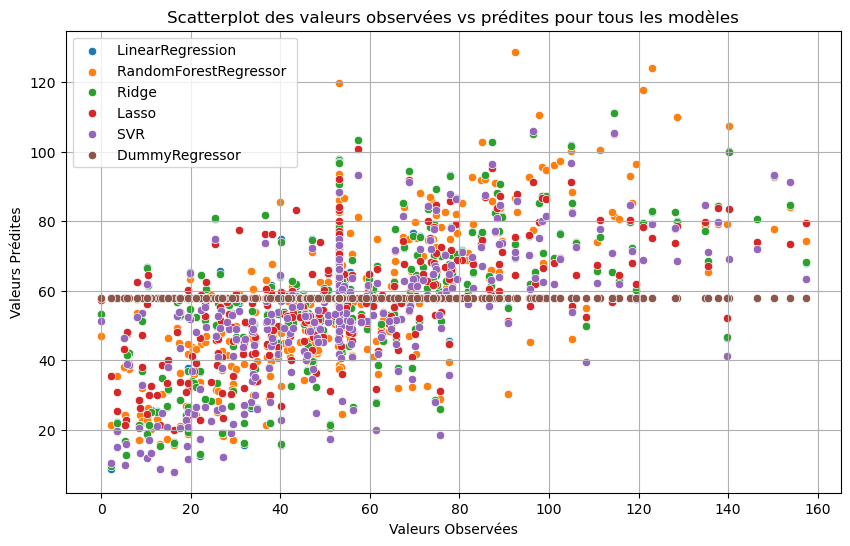

In [10]:
#                            *   Valeurs Observées et Prédites pour tous les modèles   *  

plt.figure(figsize=(10, 6))
for modele in df_resultats_predictions['Modèle'].unique():
    predictions_modele = df_resultats_predictions[df_resultats_predictions['Modèle'] == modele ]
    sns.scatterplot(x='Observée', y='Prédite', data=predictions_modele, label=modele)

plt.title('Scatterplot des valeurs observées vs prédites pour tous les modèles')
plt.xlabel('Valeurs Observées')
plt.ylabel('Valeurs Prédites')
plt.legend()
plt.grid(True)
plt.show()



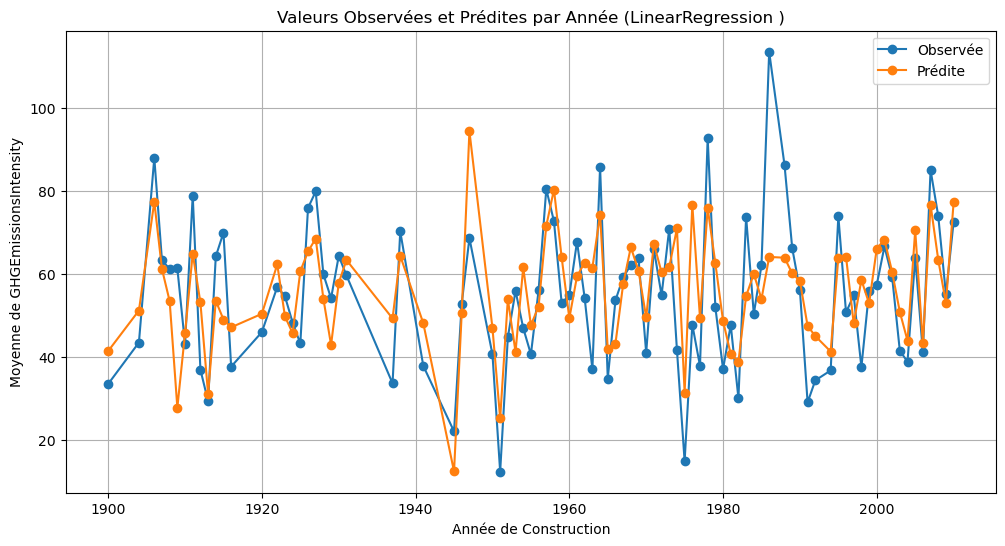

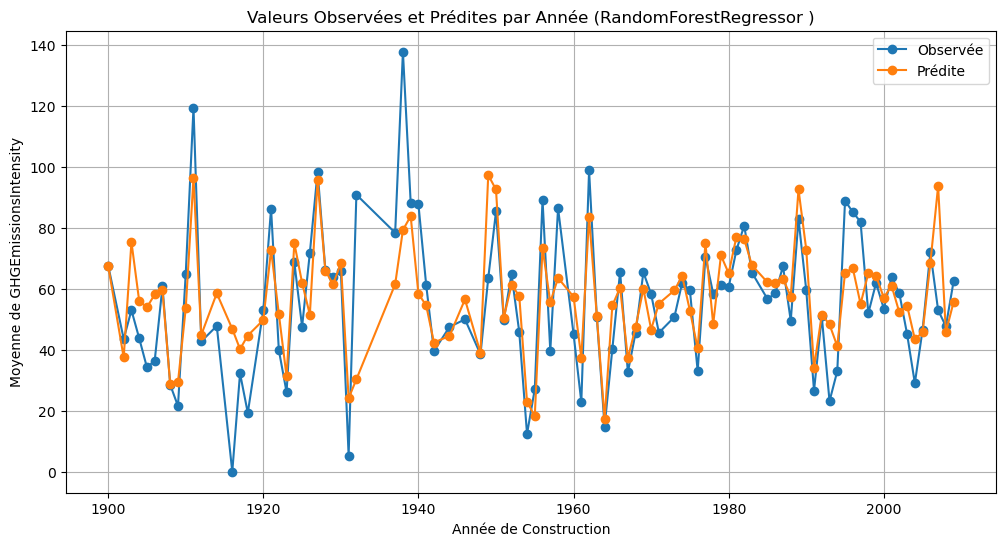

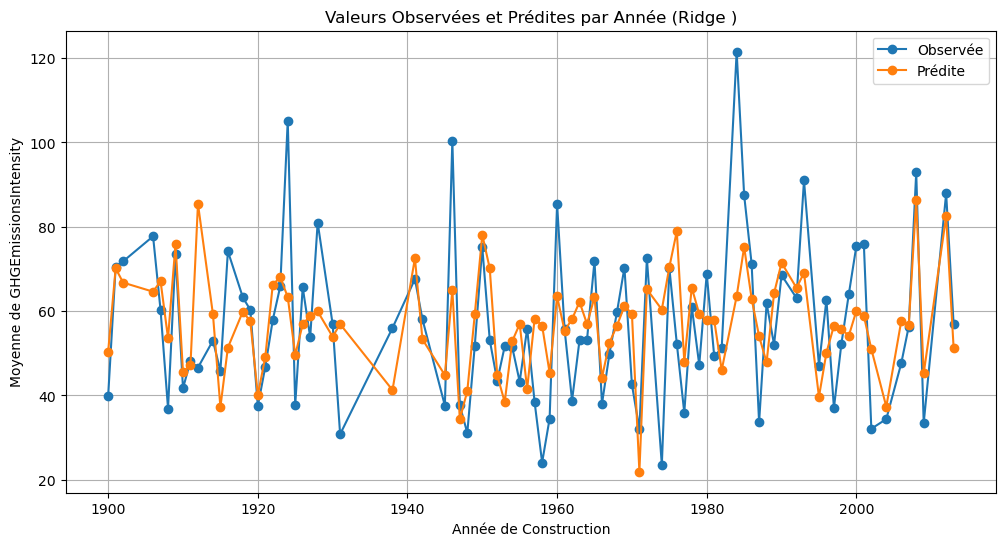

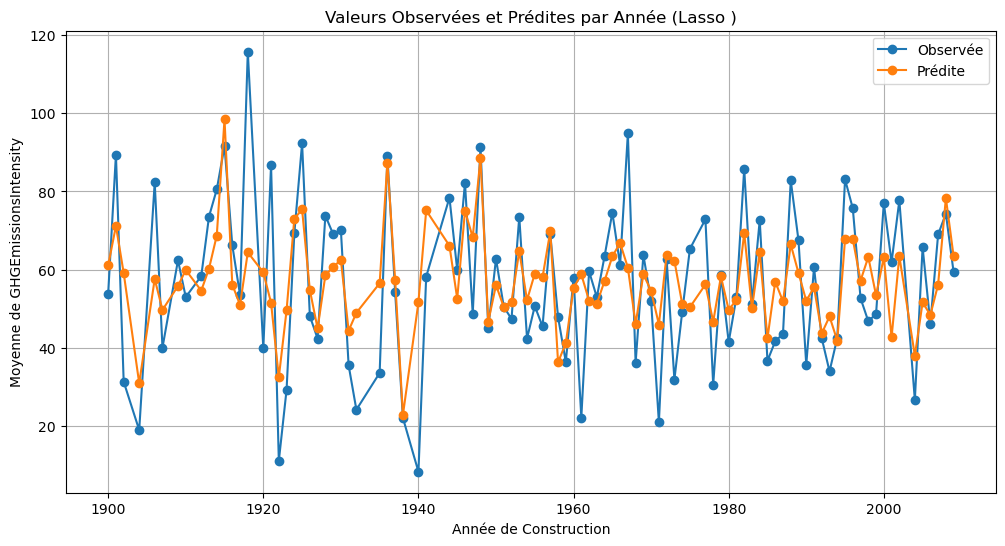

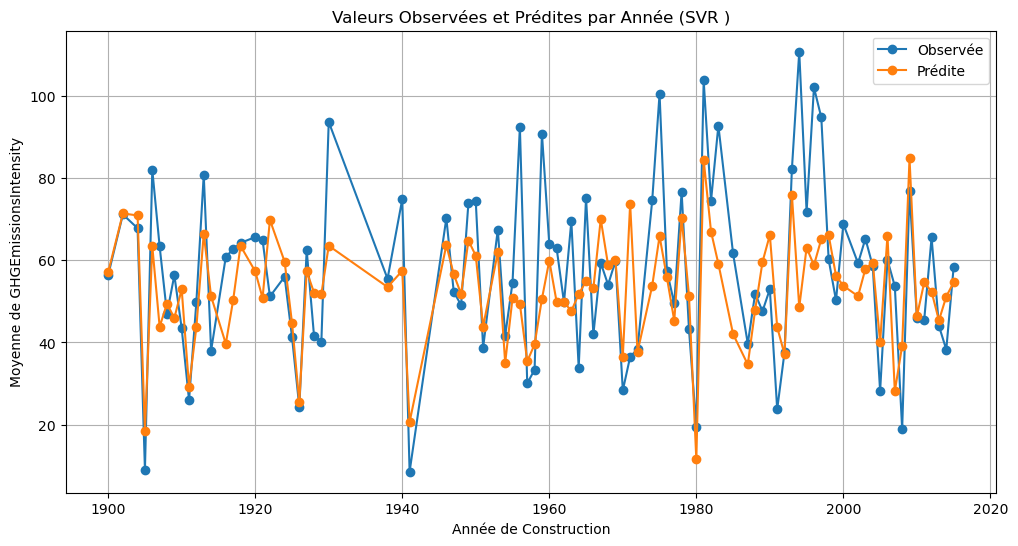

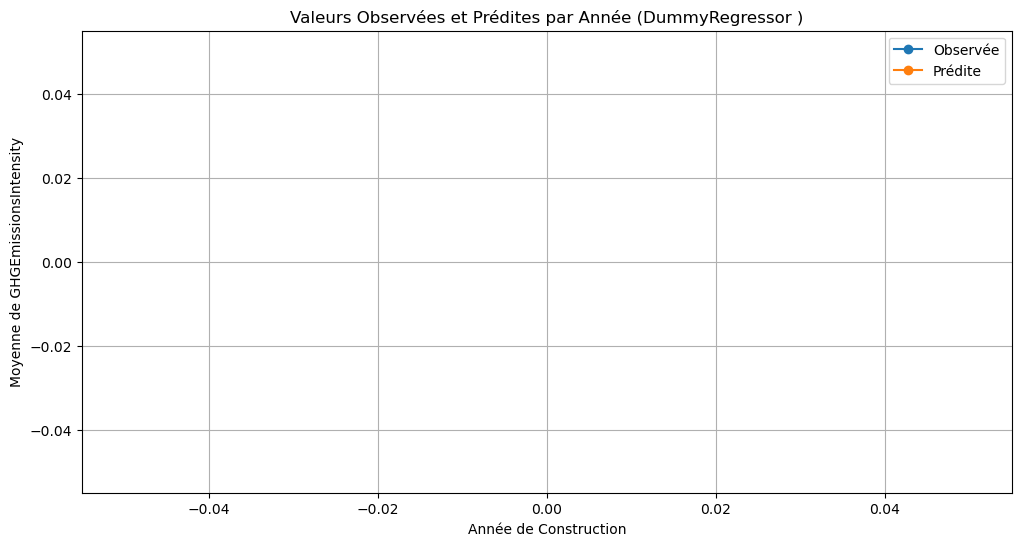

In [11]:
#                       *   Visualisation des Valeurs Observées et Prédites pour chaque modèles   *       

# Liste des modèles que vous avez évalués
modele_names = df_resultats_predictions['Modèle'].unique()

# Boucle pour créer un graphique distinct pour chaque modèle
for model_name in modele_names:
    # DataFrame des prédictions pour le modèle actuel
    predictions_df = df_resultats_predictions[df_resultats_predictions['Modèle'] == model_name]

    # Groupement des prédictions par année
    predictions_by_year = predictions_df.groupby(df_modeles['YearBuilt'])['Observée', 'Prédite'].mean().reset_index()

    # Créer un graphique à lignes pour visualiser les valeurs observées et prédites par année
    plt.figure(figsize=(12, 6))
    plt.plot(predictions_by_year['YearBuilt'], predictions_by_year['Observée'], label='Observée', marker='o', linestyle='-')
    plt.plot(predictions_by_year['YearBuilt'], predictions_by_year['Prédite'], label='Prédite', marker='o', linestyle='-')

    plt.xlabel("Année de Construction")
    plt.ylabel("Moyenne de GHGEmissionsIntensity")
    plt.title(f"Valeurs Observées et Prédites par Année ({model_name})")
    plt.legend()
    plt.grid(True)
    plt.show()


# HYPERPARAMETRE RANDOMIZEDSEARCHCV

In [12]:
#                                 *   Affichages avec les Hyperparamétres   *

#Configuration du paramétres des modèles
modele_configs = [
        ('RandomForest Regression', RandomForestRegressor(random_state=42),
         {
             'n_estimators': [100, 200, 300, 400],
             'max_depth': [None, 10, 20],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 4]
         }),
    ('Ridge Regression', Ridge(), { 'alpha': [0.1, 1.0, 10.0],
                                   'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}),
    ('Lasso Regression', Lasso(), {'alpha': [0.1, 1.0, 10.0]}),
    ('SVR', SVR(), {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'poly', 'rbf'], 'gamma': ['scale', 'auto']}),
    ('Linear Regression', LinearRegression(), None),
    ('Dummy Regression', DummyRegressor(), None)
]

df_resultats_hyper = []

for modele_config in modele_configs:
    nom_modele, modele, hyperparametres = modele_config
    df_resultats_hyper.append(analyse_modele(df_modeles, 'SiteEUIWN(kBtu/sf)', modele, hyperparametres))
    df_resultats_hyper.append(analyse_modele(df_modeles, 'SiteEUIWN(kBtu/sf)', modele, hyperparametres, sans_ENERGYSTARScore=True))

    # Convertissez les tuples (resultats_df, predictions_df) en DataFrames séparés
    resultats_df_hp = [result[0] for result in df_resultats_hyper]
    predictions_df_hp = [result[1] for result in df_resultats_hyper]

# Concaténez les DataFrames de résultats en un seul DataFrame
df_resultats_modele_hp = pd.concat(resultats_df_hp, ignore_index=True)
df_resultats_predictions_hp = pd.concat(predictions_df_hp, ignore_index=True)


In [13]:
print("Résultats des scores avec les Hyperparametres: \n") 
df_resultats_modele_hp

Résultats des scores avec les Hyperparametres: 



,Modèle,Cible,R2 Entraînement,R2 Validation,RMSE Entraînement,RMSE Validation,MAE Entraînement,MAE Validation,Temps Entraînement,Meilleurs Hyperparamètres
0,RandomForestRegressor,SiteEUIWN(kBtu/sf),0.889896,0.504982,10.512233,22.132594,7.507947,16.048106,66.286254,"{'n_estimators': 400, 'min_samples_split': 5, ..."
1,RandomForestRegressor (Sans_ENERGYSTAR),SiteEUIWN(kBtu/sf),0.490091,0.239376,22.622455,27.435110,16.690828,20.825473,61.900037,"{'n_estimators': 400, 'min_samples_split': 2, ..."
2,Ridge,SiteEUIWN(kBtu/sf),0.407134,0.405046,24.393351,24.264055,18.099133,18.072974,1.505787,"{'solver': 'sparse_cg', 'alpha': 1.0}"
3,Ridge (Sans_ENERGYSTAR),SiteEUIWN(kBtu/sf),0.221202,0.157702,27.957971,28.870512,21.225848,22.221994,0.133169,"{'solver': 'svd', 'alpha': 1.0}"
4,Lasso,SiteEUIWN(kBtu/sf),0.402801,0.411451,24.482346,24.133090,18.185697,18.008948,0.057366,{'alpha': 0.1}
5,Lasso (Sans_ENERGYSTAR),SiteEUIWN(kBtu/sf),0.215285,0.177694,28.063988,28.525839,21.314621,21.947731,0.057372,{'alpha': 0.1}
6,SVR,SiteEUIWN(kBtu/sf),0.366562,0.419361,25.214223,23.970364,17.664026,17.294009,1.976214,"{'kernel': 'linear', 'gamma': 'scale', 'C': 1.0}"
7,SVR (Sans_ENERGYSTAR),SiteEUIWN(kBtu/sf),0.216412,0.164691,28.043827,28.750478,19.114063,21.235325,2.208811,"{'kernel': 'rbf', 'gamma': 'auto', 'C': 10.0}"
8,LinearRegression,SiteEUIWN(kBtu/sf),0.407123,0.404054,24.393593,24.284265,18.101295,18.097585,0.007982,None
9,LinearRegression (Sans_ENERGYSTAR),SiteEUIWN(kBtu/sf),0.221228,0.156165,27.957520,28.896847,21.225673,22.250143,0.010973,None


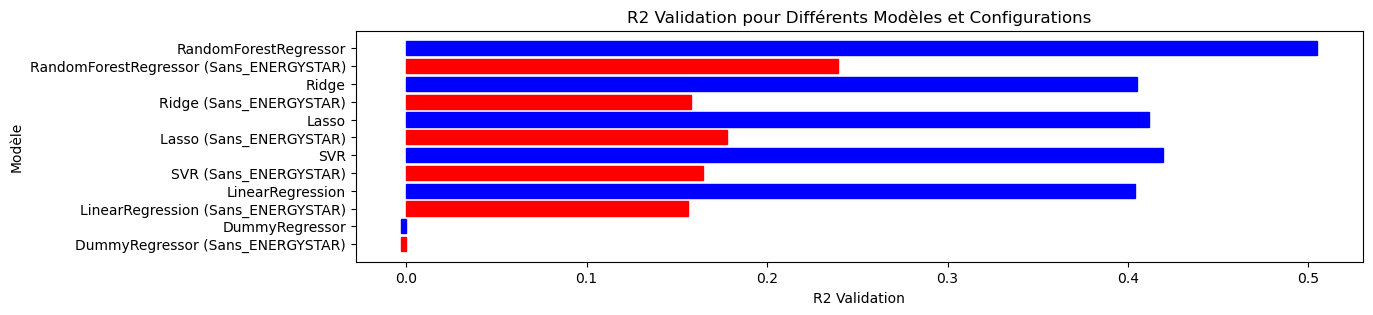

In [14]:
import matplotlib.pyplot as plt

# Sélectionnez les résultats de R2 pour la validation
r2_val_results = df_resultats_modele_hp[df_resultats_modele_hp['Cible'] == 'SiteEUIWN(kBtu/sf)']['R2 Validation']

# Sélectionnez les noms des modèles
noms_modeles = df_resultats_modele_hp['Modèle'].unique()

# Créez une liste pour stocker les couleurs des barres
couleurs = []

# Parcourez les noms des modèles et déterminez la couleur en fonction de la présence de ENERGYSTARScore
for modele in noms_modeles:
    if 'Sans_ENERGYSTAR' in modele:
        couleurs.append('red')  # Modèle avec "Sans_ENERGYSTAR" en rouge
    else:
        couleurs.append('blue')  # Autres modèles en bleu

# Créez un graphique à barres pour les valeurs R2 de validation avec des couleurs définies
plt.figure(figsize=(13, 3))
bars = plt.barh(noms_modeles, r2_val_results)

# Appliquez les couleurs aux barres
for i, couleur in enumerate(couleurs):
    bars[i].set_color(couleur)

plt.xlabel('R2 Validation')
plt.ylabel('Modèle')
plt.title('R2 Validation pour Différents Modèles et Configurations')
plt.gca().invert_yaxis()  # Inverser l'ordre des modèles
plt.show()


#### La variable "ENERGYSTARScore" a une forte contribution positive aux differents modèles. On peut voir l'écart important des scores AVEC la variable en bleu et SANS en rouge.

In [15]:
print("Résultats des prédictions avec les Hyperparametres: \n") 
df_resultats_predictions_hp.head()

Résultats des prédictions avec les Hyperparametres: 



,Modèle,Cible,Observée,Prédite
0,RandomForestRegressor,SiteEUIWN(kBtu/sf),153.699997,84.783995
1,RandomForestRegressor,SiteEUIWN(kBtu/sf),53.799999,51.880316
2,RandomForestRegressor,SiteEUIWN(kBtu/sf),38.000000,51.730338
3,RandomForestRegressor,SiteEUIWN(kBtu/sf),74.300003,70.129870
4,RandomForestRegressor,SiteEUIWN(kBtu/sf),45.500000,47.960485


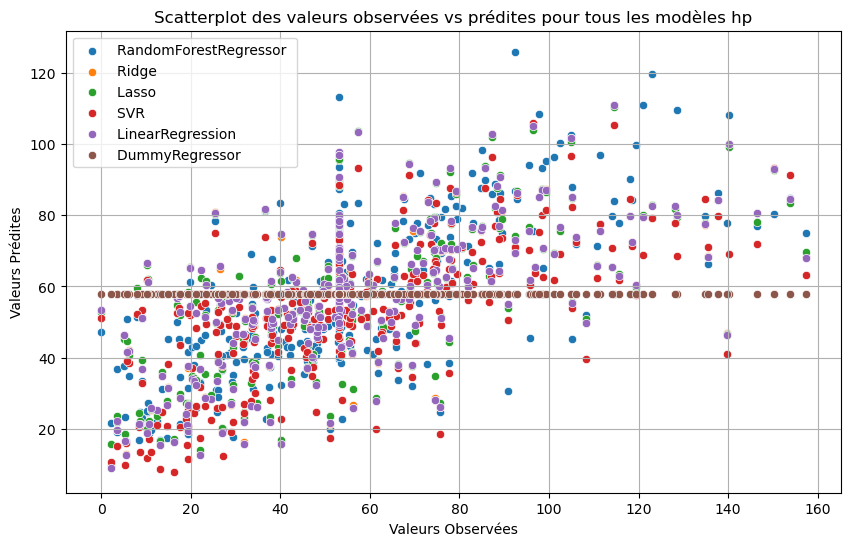

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Parcourez les noms de modèle uniques dans le DataFrame
for modele_hp in df_resultats_predictions_hp['Modèle'].unique():
    if "(Sans_ENERGYSTAR)" not in modele_hp:  
        predictions_modele_hp = df_resultats_predictions_hp[df_resultats_predictions_hp['Modèle'] == modele_hp]
        sns.scatterplot(x='Observée', y='Prédite', data=predictions_modele_hp, label=modele_hp)

plt.title('Scatterplot des valeurs observées vs prédites pour tous les modèles hp')
plt.xlabel('Valeurs Observées')
plt.ylabel('Valeurs Prédites')
plt.legend()
plt.grid(True)
plt.show()


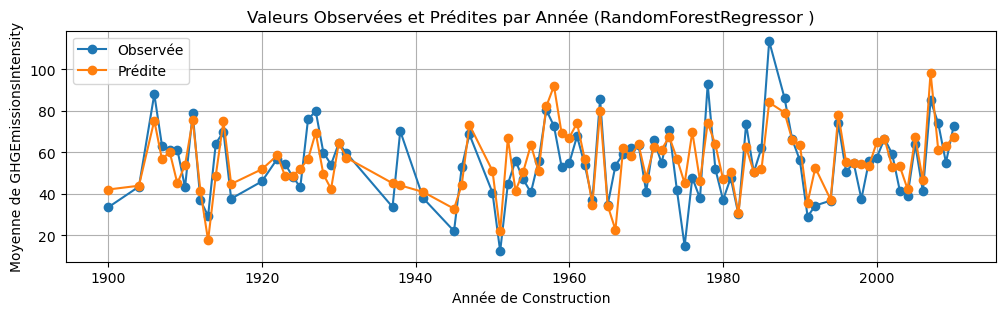

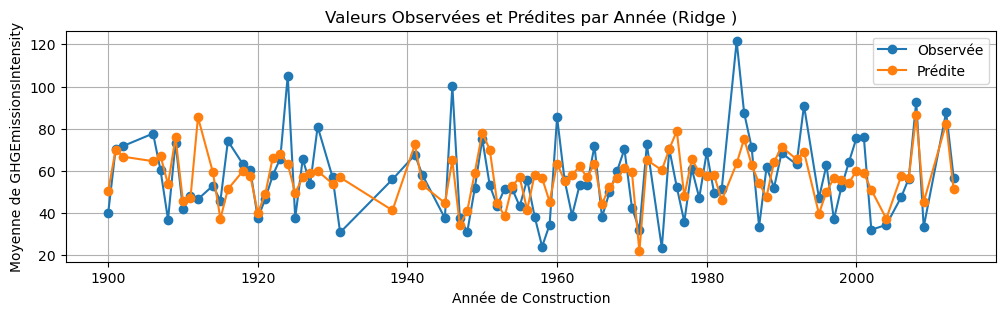

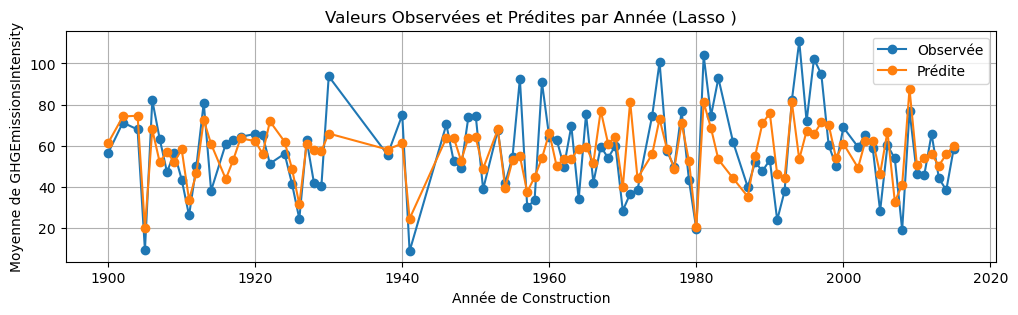

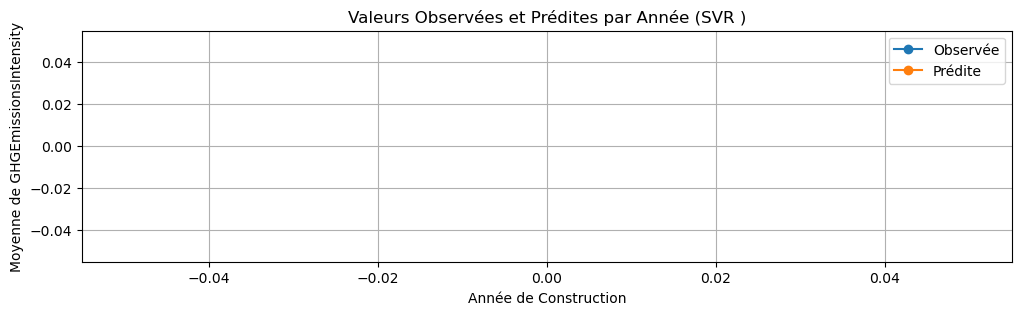

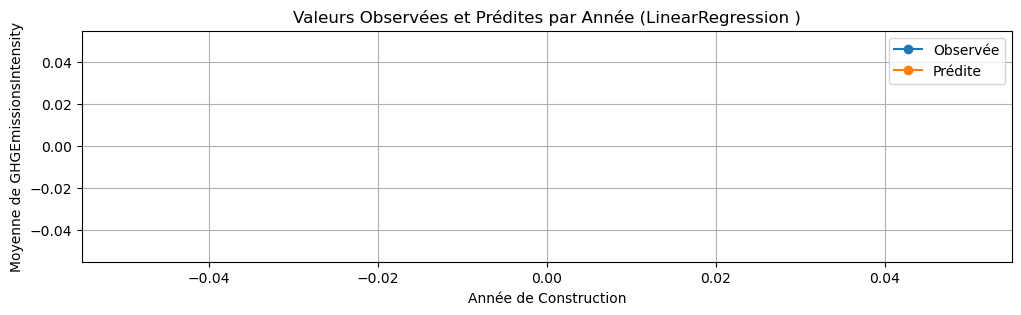

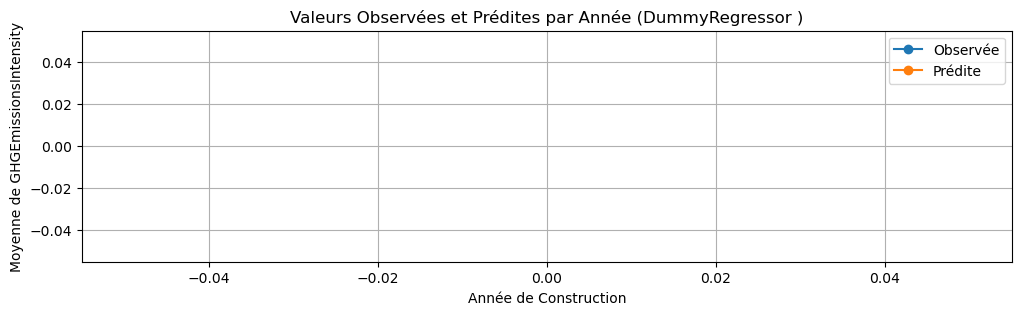

In [17]:
# Liste des modèles que vous avez évalués
modele_names = df_resultats_predictions_hp['Modèle'].unique()

# Boucle pour créer un graphique distinct pour chaque modèle (en excluant les modèles "Sans_ENERGYSTAR")
for model_name in modele_names:
    if "(Sans_ENERGYSTAR)" not in model_name:
        # DataFrame des prédictions pour le modèle actuel
        predictions_df = df_resultats_predictions_hp[df_resultats_predictions_hp['Modèle'] == model_name]

        # Groupement des prédictions par année
        predictions_by_year = predictions_df.groupby(df_modeles['YearBuilt'])['Observée', 'Prédite'].mean().reset_index()

        # Créer un graphique à lignes pour visualiser les valeurs observées et prédites par année
        plt.figure(figsize=(12, 3))
        plt.plot(predictions_by_year['YearBuilt'], predictions_by_year['Observée'], label='Observée', marker='o', linestyle='-')
        plt.plot(predictions_by_year['YearBuilt'], predictions_by_year['Prédite'], label='Prédite', marker='o', linestyle='-')

        plt.xlabel("Année de Construction")
        plt.ylabel("Moyenne de GHGEmissionsIntensity")
        plt.title(f"Valeurs Observées et Prédites par Année ({model_name})")
        plt.legend()
        plt.grid(True)
        plt.show()


## GRIDSEARCHCV

In [18]:
#Definir les Hyperparametre pour GridSearchCv 

rfr_hp = {'n_estimators': [170, 180, 190, 200, 210, 220, 230],
          'min_samples_split': [2, 3, 4, 5, 6, 7, 8],
          'min_samples_leaf': [0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3],
          'max_depth': [16, 17, 18, 19, 20, 21, 22, 23, 24]  
}

ridge_hp = {'solver': ['cholesky'], 'alpha':[0.5, 1.0, 2.0, 3.0, 4.0]}

lasso_hp = {'alpha':[0.1, 0.2, 0.3, 0.4]}

svr_hp = {'kernel': ['linear'], 'gamma': ['scale'], 'C': [6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]}

In [19]:

resultats_gcv = []

# Exemple d'utilisation avec GridSearchCV and RandomForestRegressor
resultats_gcv.append(analyse_modele(df_modeles, 'SiteEUIWN(kBtu/sf)', RandomForestRegressor(random_state=42), rfr_hp, grid_search=True))
resultats_gcv.append(analyse_modele(df_modeles, 'SiteEUIWN(kBtu/sf)', Ridge(), ridge_hp, grid_search=True))
resultats_gcv.append(analyse_modele(df_modeles, 'SiteEUIWN(kBtu/sf)', LinearRegression(), grid_search=True))
resultats_gcv.append(analyse_modele(df_modeles, 'SiteEUIWN(kBtu/sf)', Lasso(), lasso_hp, grid_search=True))
resultats_gcv.append(analyse_modele(df_modeles, 'SiteEUIWN(kBtu/sf)', SVR(), svr_hp, grid_search=True))


# Convertissez les tuples (resultats_df, predictions_df) en DataFrames séparés
resultats_df_gcv = [result[0] for result in resultats_gcv]
predictions_df_gcv = [result[1] for result in resultats_gcv]

# Concaténez les DataFrames de résultats en un seul DataFrame
df_resultats_modele_gcv = pd.concat(resultats_df_gcv, ignore_index=True)
df_resultats_predictions_gcv = pd.concat(predictions_df_gcv, ignore_index=True)


In [20]:
print('Résultat GridSearchCv : ')
df_resultats_modele_gcv

Résultat GridSearchCv : 


,Modèle,Cible,R2 Entraînement,R2 Validation,RMSE Entraînement,RMSE Validation,MAE Entraînement,MAE Validation,Temps Entraînement,Meilleurs Hyperparamètres
0,RandomForestRegressor,SiteEUIWN(kBtu/sf),0.888610,0.502035,10.573433,22.198362,7.559243,16.138367,3293.660111,"{'max_depth': 23, 'min_samples_leaf': 1, 'min_..."
1,Ridge,SiteEUIWN(kBtu/sf),0.406897,0.406253,24.398228,24.239428,18.112747,18.063097,0.074126,"{'alpha': 4.0, 'solver': 'cholesky'}"
2,LinearRegression,SiteEUIWN(kBtu/sf),0.407123,0.404054,24.393593,24.284265,18.101295,18.097585,0.008978,None
3,Lasso,SiteEUIWN(kBtu/sf),0.402801,0.411451,24.482346,24.133090,18.185697,18.008948,0.069324,{'alpha': 0.1}
4,SVR,SiteEUIWN(kBtu/sf),0.373307,0.419090,25.079601,23.975970,17.597450,17.285243,3.736611,"{'C': 12.0, 'gamma': 'scale', 'kernel': 'linear'}"


In [21]:
df_resultats_predictions_gcv.head()

,Modèle,Cible,Observée,Prédite
0,RandomForestRegressor,SiteEUIWN(kBtu/sf),153.699997,82.886502
1,RandomForestRegressor,SiteEUIWN(kBtu/sf),53.799999,52.636648
2,RandomForestRegressor,SiteEUIWN(kBtu/sf),38.000000,51.390355
3,RandomForestRegressor,SiteEUIWN(kBtu/sf),74.300003,71.128037
4,RandomForestRegressor,SiteEUIWN(kBtu/sf),45.500000,48.241906


# 

# BOOST

In [31]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

# Grilles d'hyperparamètres d'échantillonnage pour chaque algorithme de boosting
xgboost_hp = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 4, 5]
}

gradient_boost_hp = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 4, 5]
}

adaboost_hp = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1.0]
}

In [38]:
#Utilisation de la fonction
resultats_boost = []

resultats_boost.append(analyse_modele(df_modeles, target , XGBRegressor(), xgboost_hp))
resultats_boost.append(analyse_modele(df_modeles, target , GradientBoostingRegressor(), gradient_boost_hp))
resultats_boost.append(analyse_modele(df_modeles, target , AdaBoostRegressor(), adaboost_hp))

# Convertissez les tuples (resultats_df, predictions_df) en DataFrames séparés
resultats_df_boost = [result[0] for result in resultats_boost]
predictions_df_boost = [result[1] for result in resultats_boost]

# Concaténez les DataFrames de résultats en un seul DataFrame
df_resultats_modele_boost = pd.concat(resultats_df_boost, ignore_index=True)
df_resultats_predictions_boost = pd.concat(predictions_df_boost, ignore_index=True)

In [35]:
print('Résultat des modèles boost :')
df_resultats_modele_boost

Résultat des modèles boost :


,Modèle,Cible,R2 Entraînement,R2 Validation,RMSE Entraînement,RMSE Validation,MAE Entraînement,MAE Validation,Temps Entraînement,Meilleurs Hyperparamètres
0,XGBRegressor,SiteEUIWN(kBtu/sf),0.684217,0.530407,17.802766,21.556701,13.547056,15.915070,1.069360,"{'n_estimators': 150, 'max_depth': 3, 'learnin..."
1,GradientBoostingRegressor,SiteEUIWN(kBtu/sf),0.645499,0.509056,18.862634,22.041320,14.430001,16.396142,9.295026,"{'n_estimators': 100, 'max_depth': 3, 'learnin..."
2,AdaBoostRegressor,SiteEUIWN(kBtu/sf),0.373295,0.403911,25.079846,24.287190,19.270775,18.602505,6.261130,"{'n_estimators': 50, 'learning_rate': 0.01}"


# SHAP

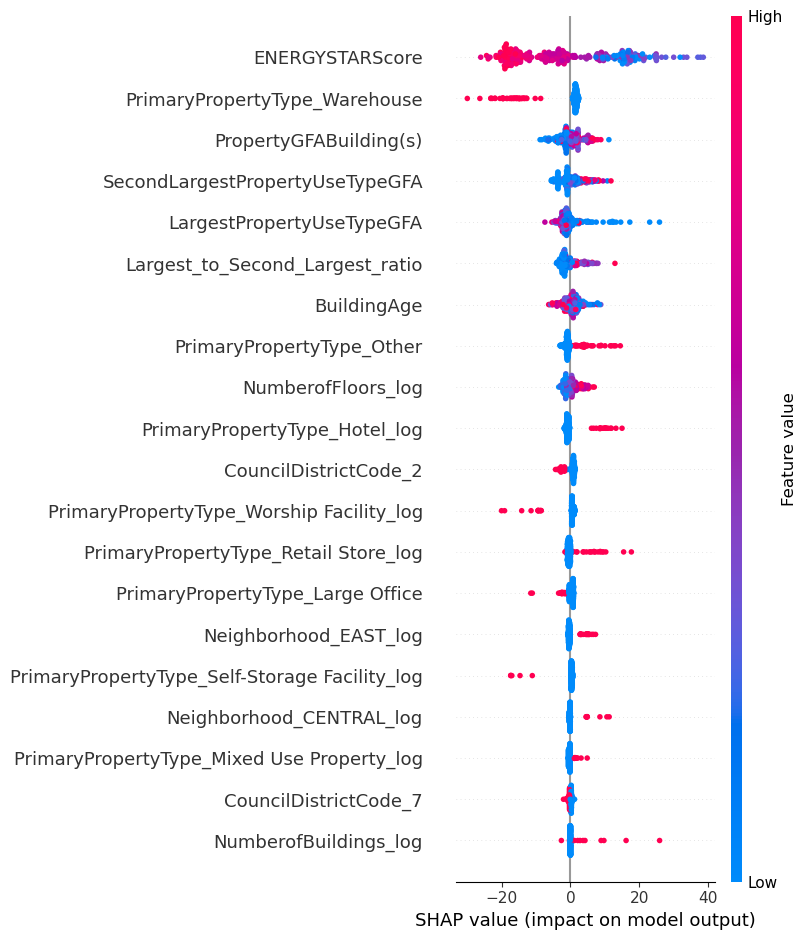

In [41]:
import shap

# Créez un modèle XGBRegressor
xgb_model = XGBRegressor(max_depth=4,
                         learning_rate=0.1,
                         n_estimators=150)


# Chargez vos données et définissez les caractéristiques et la cible
df_shap = df_modeles.drop(features_to_exclude, axis=1)
target = 'SiteEUIWN(kBtu/sf)'
features = [col for col in df_shap.columns if col != target]

# Divisez les données en ensembles d'entraînement et de validation
train, val = train_test_split(df_shap, test_size=0.2, random_state=42)

# Définissez les caractéristiques (X) et la cible (y)
X = train.drop(target, axis=1)
y = train[target]
X_val = val.drop(target, axis=1)
y_val = val[target]

# Diviser l'ensemble d'entraînement en sous-ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînez votre modèle RandomForest sur les données d'entraînement
xgb_model.fit(X_train, y_train)

# Créez un expliqueur SHAP pour le modèle XGBRegressor
shap_explainer = shap.Explainer(xgb_model, X_train)

# Calcul des valeurs SHAP pour l'ensemble de validation en désactivant la vérification d'additivité
shap_values = shap_explainer.shap_values(X_val, check_additivity=False)

# Affichez un résumé SHAP pour l'ensemble de validation
shap.summary_plot(shap_values, X_val, feature_names=features)



#### Les valeus élevé de des varibale "ENERGYSTARScore", "PimaryPropertyType_Warehouse"  on impact sur la diminution de la prédiction du modèle tandis que leurs valeurs basse contribue de manière positive à l'augmentation de la prédiction

# 

In [50]:
# Ou utilisez la liste de noms de caractéristiques appropriée
feature_names = X_val.columns.tolist()  

# Convertir le DataFrame en un tableau NumPy
Building_1 = np.array(X_val.iloc[5])  
Building_2 = np.array(X_val.iloc[100])
Building_3 = np.array(X_val.iloc[200])

# Utiliser le tableau NumPy pour calculer les valeurs SHAP
shap_values_1 = shap_explainer.shap_values(Building_1)
shap_values_2 = shap_explainer.shap_values(Building_2)
shap_values_3 = shap_explainer.shap_values(Building_3)
shap.initjs()

##### Contribution des variable sur 3 building pris par hasard : 

In [47]:
print('Diagramme de force "Building_1" : ')
shap.force_plot(shap_explainer.expected_value, shap_values_1, feature_names=feature_names, out_names = "SiteEUIWN")

Diagramme de force "Building_1" : 


In [48]:
print('Diagramme de force "Building_2" : ')
shap.force_plot(shap_explainer.expected_value, shap_values_2, feature_names=feature_names, out_names = "SiteEUIWN")

Diagramme de force "Building_2" : 


In [49]:
print('Diagramme de force "Building_3" : ')
shap.force_plot(shap_explainer.expected_value, shap_values_3, feature_names=feature_names, out_names = "SiteEUIWN")

Diagramme de force "Building_3" : 


#### Sur le 1er et 3e bâtiments, on observe une forte représentation de la variable 'ENERGYSTARScore', qui augmente les prédictions, tandis que pour le 2e bâtiment, elle contribue à leur diminution.

# DASHBORD

In [28]:
# Importez les classes nécessaires
from explainerdashboard import RegressionExplainer, ExplainerDashboard

# Créez un objet RegressionExplainer en utilisant votre modèle (rfr_model) et vos données de validation (X_val, y_val)
explainer = RegressionExplainer(rfr_model, X_val, y_val)

# Créez un tableau de bord en utilisant l'objet ExplainerDashboard en mode "inline"
dashboard = ExplainerDashboard(explainer, mode='inline')

# Exécutez le tableau de bord
dashboard.run(port =8880)



Changing class type to RandomForestRegressionExplainer...
Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Generating layout...
Calculating shap values...
Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating shap interaction values...
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Calculating dependencies...
Calculating importances...
Calculating ShadowDecTree for each individual decision tree...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard inline (terminate it with ExplainerDashboard.terminate(8880))
